<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

# openEO - Cloud Free Point Time Series of Sentinel-2 L2A
Author michele.claus@eurac.edu

Updated: 2023/05/15

In this notebook we will use openEO to retrieve a timeseries of cloud free Sentinel-2 data given a point with it's coordinates.

In [1]:
import openeo
from openeo.processes import eq, array_element
import xarray as xr

Connect to the EURAC openEO back-end

In [2]:
euracEndpoint = "https://openeo.eurac.edu"
conn = openeo.connect(euracEndpoint).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


Set the temporal extent we want to consider

In [3]:
temporal_extent = ["2018-01-01","2019-01-01"]

Set the point coordinates

In [4]:
point_coords = [46.487317942782414, 11.249706840515137]

Set the spatial extent to use in `load_collection`: we apply a little buffer to the point coordinates.

In [5]:
spatial_extent = {'west':point_coords[1],'east':point_coords[1],'north':point_coords[0],'south':point_coords[0]}

Set the collection name for the Sentinel-2 data

In [6]:
S2_collection = "S2_L2A_ALPS"

Set the bands we want to load

In [7]:
bands = ["B02","B03","B04","CLOUD_MASK"]

Load the S2 data:

In [8]:
S2_data = conn.load_collection(S2_collection,
                               temporal_extent=temporal_extent,
                               spatial_extent=spatial_extent,
                               bands=bands)

We need to mask out the cloudy pixels. We can use the CLOUD_MASK layer for this:

In [9]:
cloud_mask = S2_data.filter_bands("CLOUD_MASK").reduce_dimension(dimension="bands",reducer = lambda value: eq(array_element(value,0),1))

Apply the mask to the S2 data

In [10]:
S2_data_masked = S2_data.filter_bands(["B02","B03","B04"]).mask(cloud_mask,replacement=0)

Download the result

In [11]:
%%time
S2_data_masked.download("S2_data_masked.nc")

CPU times: user 27.7 ms, sys: 698 µs, total: 28.4 ms
Wall time: 18 s


Open the result

In [12]:
data = xr.open_dataarray("S2_data_masked.nc",decode_coords="all")
data

<xarray.DataArray (variable: 3, time: 92, y: 1, x: 1)>
[276 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T10:24:21 ... 2018-12-30T10:...
  * y            (y) float64 5.151e+06
  * x            (x) float64 6.727e+05
    spatial_ref  int32 ...
  * variable     (variable) object 'B02' 'B03' 'B04'
Attributes:
    crs:      EPSG:32632

There are many different ways of visualizing the results. Some examples can be found here for XArray: https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html

See also the Matplotlib documentation https://matplotlib.org

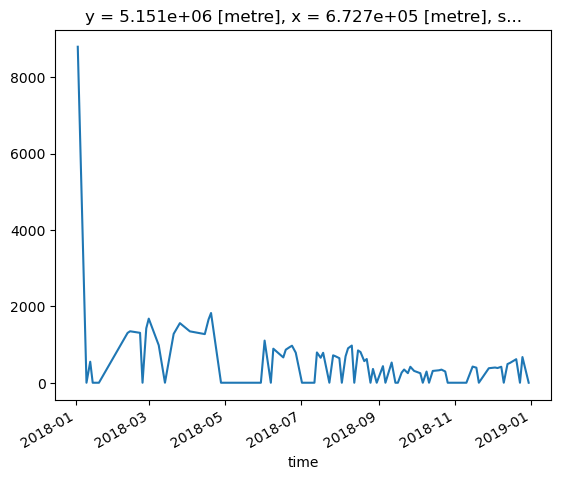

In [16]:
B04 = data.loc[dict(variable='B04')]
B04.plot()

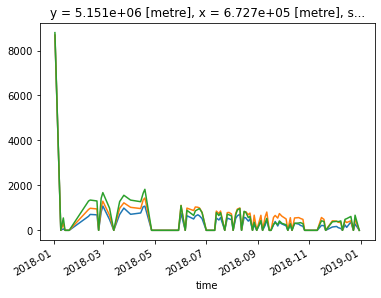

In [25]:
data.loc[dict(variable='B02')].plot()
data.loc[dict(variable='B03')].plot()
data.loc[dict(variable='B04')].plot()

If the data is still noisy, probably the clouds did not get fully filtered out. We can try to "clean" the signal by manually setting a threshold:

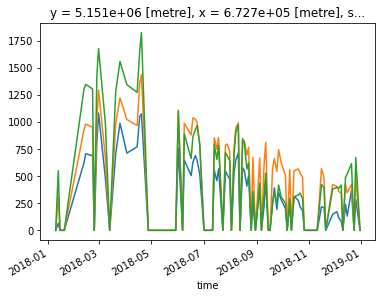

In [28]:
th = 4000
data.where(data<th).loc[dict(variable='B02')].plot()
data.where(data<th).loc[dict(variable='B03')].plot()
data.where(data<th).loc[dict(variable='B04')].plot()